## Data analysis

In [1]:
from torchvision.datasets import Omniglot
omniglot = Omniglot(root="./data", download=True)
omniglot.download()

alldata = []
for i in omniglot:
    alldata.append(i[1])
    
max(alldata)

Files already downloaded and verified
Files already downloaded and verified


963

All images are have 105 by 105 pixels

In [2]:
image = omniglot.__getitem__(300)
print(image)

import matplotlib.pyplot as plt

imgplot = plt.imshow(image[0])
# image[0].getdata()

(<PIL.Image.Image image mode=L size=105x105 at 0x7FA5A065AA20>, 15)


Lets plot a histogram of the image pixel count to see the range of pixels

(array([  469.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0., 

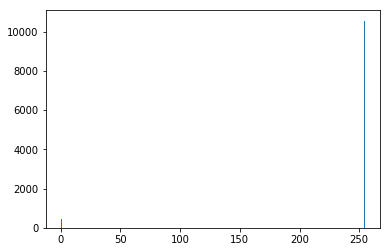

In [3]:
plt.hist(image[0].getdata(), bins=256)

In [4]:
import torchvision.transforms as transforms
import torch
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

BATCH_SIZE = 50

from myomniglot import MyOmniglot

setname = 'images_background_small1'

dataset = MyOmniglot(root='./data_generated', setname=setname, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import math

class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(43264, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 136),
        )
          
        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                

    def forward(self, x):
        
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x   

net = Net()

/home/qweenink/.local/lib/python3.5/site-packages/ipykernel_launcher.py:49: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [8]:
ENABLE_CUDA = False

if ENABLE_CUDA:
    net.cuda()
    
loss = None
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        if ENABLE_CUDA:
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss.item()))
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 5.693
[1,    11] loss: 5.958
[1,    21] loss: 5.792
[1,    31] loss: 5.164
[1,    41] loss: 5.215
[2,     1] loss: 5.009
[2,    11] loss: 4.951
[2,    21] loss: 4.617
[2,    31] loss: 5.134
[2,    41] loss: 4.598
[3,     1] loss: 4.579
[3,    11] loss: 4.844
[3,    21] loss: 4.764
[3,    31] loss: 4.296
[3,    41] loss: 4.526
[4,     1] loss: 4.236
[4,    11] loss: 4.428
[4,    21] loss: 4.028
[4,    31] loss: 4.442
[4,    41] loss: 3.994
[5,     1] loss: 3.962
[5,    11] loss: 3.919
[5,    21] loss: 3.525
[5,    31] loss: 3.817
[5,    41] loss: 4.017
[6,     1] loss: 3.650
[6,    11] loss: 3.825
[6,    21] loss: 3.617
[6,    31] loss: 3.871
[6,    41] loss: 3.897
[7,     1] loss: 3.096
[7,    11] loss: 3.425
[7,    21] loss: 3.783
[7,    31] loss: 3.542
[7,    41] loss: 3.329
[8,     1] loss: 3.071
[8,    11] loss: 3.218
[8,    21] loss: 3.089
[8,    31] loss: 3.252
[8,    41] loss: 3.255
[9,     1] loss: 2.693
[9,    11] loss: 3.165
[9,    21] loss: 2.997
[9,    31] 

KeyboardInterrupt: 

In [9]:
torch.save(net, 'cnn_extended.pt')

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [10]:
train_size = len(train_dataset)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)

correct = 0
for i, (images, labels) in enumerate(train_loader):
    if ENABLE_CUDA:
        images, labels = images.cuda(), labels.cuda()
    results = net(images)
    results = results.detach().cpu().numpy()
    for i, result in enumerate(results):
        if np.argmax(result) == labels[i]:
            correct += 1
        
print("accuracy: ", correct/train_size)

accuracy:  0.8143382352941176


In [11]:
test_size = 0
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

correct = 0
for i, (images, labels) in enumerate(test_loader):
    test_size += len(images)
    if ENABLE_CUDA:
        images, labels = images.cuda(), labels.cuda()
    results = net(images)
    results = results.detach().cpu().numpy()
    for i, result in enumerate(results):
        if np.argmax(result) == labels[i]:
            correct += 1
        
print("accuracy: ", correct/test_size)

accuracy:  0.2702205882352941
